<h1><center>Foundations of Deep Learning</center></h1>


<h2><center>Multi Layer Perceptron</center><h2>

Multiplayer Perceptron is a feed forward neural network composed of multiple layers of affine transformations followed by non linearity function. Each layer of an MLP is defined as:
$$
z^{(l)} = W^{(l)}x^{(l-1)} + b^{(l)}
$$ 

$$
x^{(l)} = f(z^{(l)})
$$

Here, $l$ denotes the layer of MLP, $W$ and $b$ are the trainable parameters called *weight* and *bias* respectively

ReLU or Rectified Linear Unit is the most common non linear layer used with MLP.
More about ReLU can be found here: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html

In this assignment you are required to do the following:

+ Create an MLP
  + Write the *forward* function for affine transformation
  + Write the *backward* function (to calculate gradients) for the affine transformation
  + Create a Neural Network by stacking these transformations

+ Train the Neural Network on Fashion MNIST Dataset
  + Write Loss Function for the training
  + Write parameter update routine
  + Run Validation 
  + Plot Train and Validation Loss Curves using Matplotlib 

+ Testing the Neural Network
  + Change the *seed* and train the neural network 10 times
  + Report the mean and variance over 10 trials on the following metrics:
    + Accuracy
    + Precision
    + Recall
    + F1
    + ROC curve

+ Change the number of parameters in the Neural Network 
  + Train a underfit model
  + Train a overfit model
  + Demostrate the difference between overfitting and underfitting


In [ ]:
#@
Name = "Rishu Verma" #@param {type:"string"}

In [3]:
import torch
import random
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as tnn
import numpy as np
!pip install torchmetrics

# select device as cuda
device = torch.device("cuda:0")

# set random seeds
seed = 1234 ## change this seed when you run trials
random.seed(seed)
torch.manual_seed(seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Gradient Update
To update gradients, from the equation of affine transformation we have:

$$
z^{(l)} = W^{(l)}x^{(l-1)} + b
$$ 

We can calulate all the partial derivations in the following fashion

$$
\frac{\partial z^{(l)}}{\partial x^{(l-1)}} = W^{(l)}
$$

$$
\frac{\partial z^{(l)}}{\partial W^{(l)}} = x^{(l-1)}
$$

$$
\frac{\partial z^{(l)}}{\partial b^{(l)}} = 1
$$

To write the *backward* function, we need one more step. *backward* functon takes *grad_output* as its input. It is the backward flow of gradients coming from the final output $\hat y$ and can be mathematically expressed as:
$$
  grad\_output = \frac{\partial \hat y}{\partial z^{(l)}}
$$

*backward* functions gives out three values:

$$
grad\_x = \frac{\partial \hat y}{\partial x^{(l-1)}} = \frac{\partial \hat y}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial x^{(l-1)}} 
$$

$$
grad\_w = \frac{\partial \hat y}{\partial W^{(l)}} = \frac{\partial \hat y}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial W^{(l)}}
$$


$$
grad\_b = \frac{\partial \hat y}{\partial b^{(l)}} =  \frac{\partial \hat y}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial b^{(l)}}
$$

In the code below, update the *forward* and *backward* functions of class LinearFunction


In [5]:
class LinearFunction(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, W, b):
    """
    # x -> input matrix of size n_samples x sdim
    # W -> transformation matrix
    # b -> bias term 
    """
    ctx.save_for_backward(x, W, b)
    # Write your affine transformation here:
    #-------------------
    xW = torch.matmul(x, W)
    z = torch.add(xW,b)
    #-------------------
    return z
    
  @staticmethod
  def backward(ctx, grad_output):
    x, W, b = ctx.saved_tensors
   
    # Write gradient updates here:
    #----------------------------
    """
    The transpose of the W matrix is taken to match the dimensions of the two matrix to support matrix multiplication
    """
    grad_x = torch.matmul(grad_output, W.t())
    grad_w = torch.matmul(x.t(), grad_output)
    grad_b = grad_output
    #-----------------------------
    return grad_x, grad_w, grad_b


Class CustomLinearLayer uses previously defined LinearFunction to create one layer of Neural Network. Look at the initial values given to $W$ and $b$.
You do not need to change anything in this class.

In [6]:
class CustomLinearLayer(torch.nn.Module):
  def __init__(self, in_features, out_features):
    super(CustomLinearLayer, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    w = torch.normal(mean = 0, std = 0.1, size = [in_features, out_features], requires_grad=True)
    b = torch.full([out_features], 0.01, requires_grad=True)
    w = torch.nn.Parameter(w)
    b = torch.nn.Parameter(b)
    self.register_parameter('w', w)
    self.register_parameter('b', b)
    self.linear_function = LinearFunction.apply
  
  def forward(self, x):
    return self.linear_function(x, self.w, self.b)

In the Neural Network class below class Below, Add two linear layers of the following sizes:
+ 784 x 512
+ 512 x 10

In the forward function, 
+ Apply layer_1 on input
+ Apply activation function on the result
+ Apply layer_2 on the result
+ Apply Softmax and return the final result

In [7]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    # Add Linear layers below 
    #-----------------------------------
    '''
      Using the CustomLinearLayer to declare the new layers in the NeuralNetwork.
    '''
    self.layer_1 = CustomLinearLayer(784,512)
    self.layer_2 = CustomLinearLayer(512,10)
    # ------------------------------------
    self.activation = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax(dim=-1)
  
  def forward(self, x):
    # Apply layers defined above:
    #-------------------------------
    output = self.layer_1(x) #Apply layer_1 on input
    output = self.activation(output) #Apply activation function on the result
    output = self.layer_2(output) #Apply layer_2 on the result (: output)
    output = self.softmax(output) #Apply Softmax and return the final result
    #-------------------------------
    return output

Fasion MNIST dataset is a set of grayscale images categorized into 10 classes. To train our neural network, first we need to define loss function. $y$ is the ground truth class label and $probs$ is the probability distribution given by our Neural Network over 10 classes, update the *forward* function of loss class below. 

$$
ce\_loss = -\frac{1}{{\#samples}}\sum^{\#samples}_i y_i.\log(probs_i)
$$

*Hint*: Try representing $y$ as one hot vector

In [8]:
class CrossEntropyLoss(torch.nn.Module):
  def __init__(self):
    super(CrossEntropyLoss, self).__init__()
  
  def forward(self, probs, y):
    #Write loss function here:
    #-------------------------------
    '''
      Implenting the CrossEntropyLoss for 10 classes (classes is taken from the size of "probs") 
      and samples will be the batchsize on which the network is trained and loss is calcluated.

      It is observed that the number of samples may not always be equal to the batch_size as:
      samples = len(dataset)/batchsize and if they are not perfect multiples then the last batch
      of the data will have size less than the batchsize.
    '''
    number_of_classes = probs.shape[1] 
    number_of_samples = y.size()[0] 
    one_hot_vector_y = torch.nn.functional.one_hot(y,number_of_classes)
    loss = -torch.div(torch.sum(torch.multiply(one_hot_vector_y, torch.log(probs))), number_of_samples)
    #-------------------------------
    return loss

In [9]:
'''
     Downloading the Data
'''
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

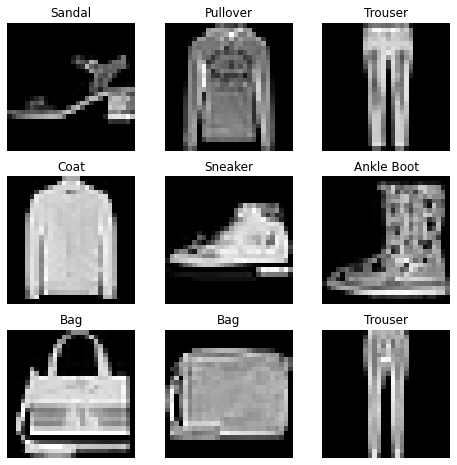

In [10]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Fashion MNIST dataset loaded from pytorch APIs only has two sets: train and test. Split the train data into train and validation sets with 50K samples in train and 10K samples in validation set. The data split should be random.

*Hint* Look for a function in *torch.utils.data*

In [11]:
# split mnist trainset into two sets: mnist trainset -> 50000 , mnist validation set -> 10000
#----------------
'''
      Spliting the training data as per the instructions with training_set as 50000 and validation set = 10000
'''
train_data, val_data = torch.utils.data.random_split(training_data, [50000, 10000])
#----------------

In [12]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [13]:
'''
      model initialization 
'''
model = NeuralNetwork().cuda()
ce_loss = CrossEntropyLoss()

1) The gradients we calculated in the start can be accessed by iterating over model.parameters() as *params.grad*. Write the parameter update rule in the training code below: 

$$
param := param - learning\_rate*gradient
$$

2) Write validation loop which runs every epoch and prints the following metrics on validation set:
  + Accuracy
  + Precision
  + Recall
  + F1 
  + roc_auc

3) Store the training loss and validation loss in each iteration and plot a graph comparing them.

Epoch 0/10 Iteration 0/49 Loss 3.6421902179718018: 
Epoch 0/10 Iteration 1/49 Loss 2.8335654735565186: 
Epoch 0/10 Iteration 2/49 Loss 2.489055633544922: 
Epoch 0/10 Iteration 3/49 Loss 2.36944580078125: 
Epoch 0/10 Iteration 4/49 Loss 2.2263412475585938: 
Epoch 0/10 Iteration 5/49 Loss 2.039961814880371: 
Epoch 0/10 Iteration 6/49 Loss 1.9673542976379395: 
Epoch 0/10 Iteration 7/49 Loss 1.9270508289337158: 
Epoch 0/10 Iteration 8/49 Loss 1.909238338470459: 
Epoch 0/10 Iteration 9/49 Loss 1.829696536064148: 
Epoch 0/10 Iteration 10/49 Loss 1.736072301864624: 
Epoch 0/10 Iteration 11/49 Loss 1.6891040802001953: 
Epoch 0/10 Iteration 12/49 Loss 1.6831843852996826: 
Epoch 0/10 Iteration 13/49 Loss 1.6354825496673584: 
Epoch 0/10 Iteration 14/49 Loss 1.6609687805175781: 
Epoch 0/10 Iteration 15/49 Loss 1.546505331993103: 
Epoch 0/10 Iteration 16/49 Loss 1.5746090412139893: 
Epoch 0/10 Iteration 17/49 Loss 1.5222103595733643: 
Epoch 0/10 Iteration 18/49 Loss 1.5270293951034546: 
Epoch 0/10 

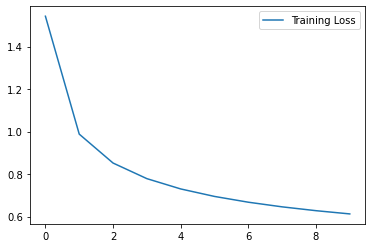

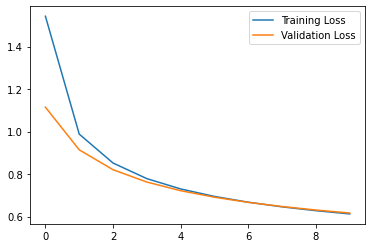

In [14]:
'''
      In this implementaion we are training the model on the train_loader and also validating the data on he validation_load.
      The below plot shows the Training and Validation loss while training the model on the 10 epochs with batch_size = 1024 (pre-defined)

      training_loss   : stores the mean training loss over each batch run for all the 10 epoch runs.
      validation_loss  : stores the mean validation loss over each batch run for all the 10 epoch runs.

      The plot shows that as the model is trained further the testing loss and training loss converges. Leading to better performance of the model. 
'''
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, AUROC, ROC

batch_size = 1024
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
valid_loader = DataLoader(val_data, batch_size=batch_size)
max_epochs = 10
learning_rate = 0.01
# Storing value of training loss and validation loss for each epoch:
# --------------
training_loss = []
validation_loss = []
# --------------

for epoch in range(max_epochs):
  loss_per_epoch = 0
  for idx, data in enumerate(train_loader):
    features, labels = data

    features = features.cuda()

    labels = labels.cuda()
    probs = model(features.reshape([-1, 784]))

    loss = ce_loss(probs, labels)
    # Recording training_loss:
    # --------------
    loss_per_epoch = loss_per_epoch + loss.item()
    # --------------
    #print("Epoch {0}/{1} Iteration {2}/{3} Loss {4}: ".format(epoch, max_epochs, idx, len(train_loader), loss))

    for param in model.parameters():
      param.grad = None

    loss.backward()

    for name, param in model.named_parameters():
      # Write paramtere update routine here:
      # --------------
      new_param = param - learning_rate * param.grad    
      # --------------
      with torch.no_grad():
        param.copy_(new_param)
        
  avg_loss_per_iter = loss_per_epoch/len(train_loader);
  training_loss.append(avg_loss_per_iter)
  loss_per_epoch_valid = 0

  # Write Validation routine here: 
  #----------------------------
  for idx, data in enumerate(valid_loader):
    features, labels = data
    features = features.cuda()
    labels = labels.cuda()

    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    roc_auc_lst = []

    with torch.no_grad():
      probs = model(features.reshape([-1, 784]))

      vloss = ce_loss(probs, labels)
      loss_per_epoch_valid = loss_per_epoch_valid + vloss.item()

      predicts = torch.argmax(probs, dim=1)

      accuracy_matrix = MulticlassAccuracy(task="multiclass", num_classes=10).to(device)
      accuracy_lst.append(accuracy_matrix(predicts, labels).item())

      precision_matrix = MulticlassPrecision(task="multiclass", num_classes=10).to(device)
      precision_lst.append(precision_matrix(predicts, labels).item())

      recall_matrix = MulticlassRecall(task="multiclass", num_classes=10).to(device)
      recall_lst.append(recall_matrix(predicts, labels).item())

      f1_matrix = MulticlassF1Score(task="multiclass", num_classes=10).to(device)
      f1_lst.append(f1_matrix(predicts, labels).item())

      roc_auc_matrix = AUROC(task="multiclass", num_classes=10).to(device)
      roc_auc_lst.append(roc_auc_matrix(probs, labels).item())

  print("Epoch {0}/{1} Accuracy {2} Precision {3}: Recall {4} F1 {5} ROC_AUC {6}".format(epoch , len(valid_loader), sum(accuracy_lst)/len(accuracy_lst), sum(precision_lst)/len(precision_lst), sum(recall_lst)/len(recall_lst), sum(f1_lst)/len(f1_lst), sum(roc_auc_lst)/len(roc_auc_lst)))
  avg_valid_loss_per_iter = loss_per_epoch_valid/len(valid_loader)
  validation_loss.append(avg_valid_loss_per_iter)

plt.plot(training_loss, label='Training Loss')
plt.legend()
plt.show()

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()
plt.show()

Testing the Neural Network
  + Change the *seed* and train the neural network 10 times
  + Report the mean and variance over 10 trials on the following metrics:
    + Accuracy
    + Precision
    + Recall
    + F1
    + ROC curve



In [42]:
'''
      In this implementaion we are training the model 10 times on the the train_loader, by chaingng the seed value and then test it on the test_load
      
      accuracy_postTrials   : stores the mean accuracy score on test_load for each trail.
      precision_postTrials  : stores the mean precision score on test_load for each trail.
      recall_postTrials : stores the mean recall score on test_load for each trail.
      f1_postTrials: stores the mean F1 score on test_load for each trail.
      roc_auc_postTrials: stores the mean roc_auc score on test_load for each trail.

'''
#----------------------------------------------------

accuracy_postTrials = []
precision_postTrials = []
recall_postTrials = []
f1_postTrials= []
roc_auc_postTrials = []

for iter in range(0,10):
  seed = random.randrange(1024,3456) ## change this seed when you run trials
  random.seed(seed)
  torch.manual_seed(seed)

  print(f"Seed: {seed}")
  model = NeuralNetwork().cuda()

  for epoch in range(max_epochs):
    for idx, data in enumerate(train_loader):
      features, labels = data
      features = features.cuda()
      labels = labels.cuda()
      probs = model(features.reshape([-1, 784]))
      #print("Epoch {0}/{1} Iteration {2}/{3} Loss {4}: ".format(epoch, max_epochs, idx, len(train_loader), loss))
      loss = ce_loss(probs, labels)
      for param in model.parameters():
        param.grad = None

      loss.backward()

      for name, param in model.named_parameters():
        new_param = param - learning_rate * param.grad    

        with torch.no_grad():
          param.copy_(new_param)

  accuracy_lst = []
  precision_lst = []
  recall_lst = []
  f1_lst = []
  roc_auc_lst = []

  for idx, data in enumerate(test_loader):
    features, labels = data
    features = features.cuda()
    labels = labels.cuda()

  
    with torch.no_grad():
      probs = model(features.reshape([-1, 784]))
      predicts = torch.argmax(probs, dim=1)

      accuracy_matrix = MulticlassAccuracy(task="multiclass", num_classes=10).to(device)
      accuracy_lst.append(accuracy_matrix(predicts, labels).item()*labels.size()[0])

      precision_matrix = MulticlassPrecision(task="multiclass", num_classes=10).to(device)
      precision_lst.append(precision_matrix(predicts, labels).item()*labels.size()[0])

      recall_matrix = MulticlassRecall(task="multiclass", num_classes=10).to(device)
      recall_lst.append(recall_matrix(predicts, labels).item()*labels.size()[0])

      f1_matrix = MulticlassF1Score(task="multiclass", num_classes=10).to(device)
      f1_lst.append(f1_matrix(predicts, labels).item()*labels.size()[0])

      roc_auc_matrix = AUROC(task="multiclass", num_classes=10).to(device)
      roc_auc_lst.append(roc_auc_matrix(probs, labels).item()*labels.size()[0])

  #Weighted_Average as last batch_size if not same as all.
  accuracy_postTrials.append(sum(accuracy_lst)/len(test_loader.dataset))
  precision_postTrials.append(sum(precision_lst)/len(test_loader.dataset))
  recall_postTrials.append(sum(recall_lst)/len(test_loader.dataset))
  f1_postTrials.append(sum(f1_lst)/len(test_loader.dataset))
  roc_auc_postTrials.append(sum(roc_auc_lst)/len(test_loader.dataset))
  
print(f"Accuracy_PostTrials {accuracy_postTrials} precision_postTrials {precision_postTrials} recall_postTrials {recall_postTrials} f1_postTrials {f1_postTrials} roc_auc_postTrials {roc_auc_postTrials}")
print("Mean: Accuracy {2} Precision {3}: Recall {4} F1 {5} roc_auc {6}".format(epoch , len(valid_loader), sum(accuracy_postTrials)/len(accuracy_postTrials), sum(precision_postTrials)/len(precision_postTrials), sum(recall_postTrials)/len(recall_postTrials), sum(f1_postTrials)/len(f1_postTrials), sum(roc_auc_postTrials)/len(roc_auc_postTrials)))
print("Variance: Accuracy {2} Precision {3}: Recall {4} F1 {5} roc_auc {6}".format(epoch , len(valid_loader), np.var(accuracy_postTrials), np.var(precision_postTrials), np.var(recall_postTrials), np.var(f1_postTrials), np.var(roc_auc_postTrials)))
    

Seed: 1898
Seed: 2287
Seed: 1658
Seed: 2871
Seed: 1259
Seed: 2603
Seed: 2250
Seed: 2958
Seed: 2532
Seed: 2015
Accuracy_PostTrials [0.7797717787742615, 0.7816561443328858, 0.7828337652206421, 0.7740308387756347, 0.7818683427810669, 0.7924730932235717, 0.7874010787963868, 0.7901204986572266, 0.788714882850647, 0.7892341684341431] precision_postTrials [0.7773196880340576, 0.7797733465194702, 0.780192604637146, 0.7715264959335327, 0.7802674278259277, 0.790047458076477, 0.7840385536193848, 0.7879504689216614, 0.7870594895362854, 0.7857215991973877] recall_postTrials [0.7797717787742615, 0.7816561443328858, 0.7828337652206421, 0.7740308387756347, 0.7818683427810669, 0.7924730932235717, 0.7874010787963868, 0.7901204986572266, 0.788714882850647, 0.7892341684341431] f1_postTrials [0.7766911413192749, 0.7793644353866577, 0.7799691547393799, 0.7713239065170288, 0.7793094509124756, 0.7895264785766601, 0.784501943397522, 0.7875038537979125, 0.78721320810318, 0.7860152760505676] roc_auc_postTrials [

+ Change the number of parameters in the Neural Network 
  + Train an underfit model
  + Train a overfit model
  + Demostrate the difference between overfitting and underfitting. Give detailed reasoning.

In [61]:
'''
      Below is the implmentation of the UnderfirNeuralNetwork in which the number of neurons per network are decreased.

'''
class UnderfitNeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(UnderfitNeuralNetwork, self).__init__()

    #reducing the number of neurons in the layers for underfiting
    self.layer_1 = CustomLinearLayer(784,5)
    self.layer_2 = CustomLinearLayer(5,10)
    self.activation = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax(dim=-1)
  
  def forward(self, x):
    # Apply layers defined above:
    #-------------------------------
    output = self.layer_1(x) #Apply layer_1 on input
    output = self.activation(output) #Apply activation function on the result
    output = self.layer_2(output) #Apply layer_2 on the result (: output)
    output = self.softmax(output) #Apply Softmax and return the final result
    #-------------------------------
    return output

Training_Loss [2.2563399052133364, 2.20307656210296, 2.1636683697603187, 2.1270131529593956, 2.0881856023048866, 2.038044168024647, 1.9616913917113323, 1.8480031028085826, 1.7027479653455773, 1.555671475371536, 1.4330494306525405, 1.3411138763233108, 1.271401312886452, 1.2152069393469362, 1.1679171080491981, 1.1271931808822009, 1.0917371341160365, 1.060752382083815, 1.033623154066047, 1.0098324442396358, 0.9889035906110492, 0.9704114952865912, 0.953987297963123, 0.9393094924031472, 0.9260987323157641, 0.9141333309971557, 0.9032168753293096, 0.8931834478767551, 0.8838934192852098, 0.8752353337346291, 0.8671141923690329, 0.8594607747330958, 0.8522075037566983, 0.845298344991645, 0.8386973276430246, 0.8323647233904624, 0.8262723331548729, 0.8203967700199205, 0.8147240305433467, 0.8092390092051759, 0.8039294262321628, 0.7987839457940082, 0.7937903611027465, 0.7889419392663606, 0.784229406288692, 0.7796474634384623, 0.7751928129974677, 0.7708601927270695, 0.7666444790606596, 0.7625412880157

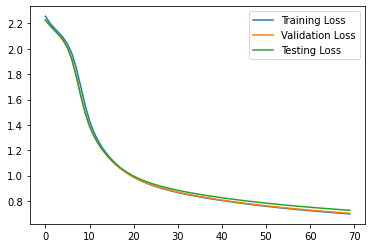

In [63]:
#Training and Testing UnderFitting Model
training_loss = []
testing_loss = []
validation_loss = []
#---------------------
model_underfit = UnderfitNeuralNetwork().cuda()

for epoch in range(70):
  loss_per_epoch = 0
  for idx, data in enumerate(train_loader):
    features, labels = data
    features = features.cuda()
    labels = labels.cuda()
    probs = model_underfit(features.reshape([-1, 784]))
    loss = ce_loss(probs, labels)
    loss_per_epoch = loss_per_epoch + loss.item()

    for param in model_underfit.parameters():
      param.grad = None

    loss.backward()

    for name, param in model_underfit.named_parameters():
      new_param = param - learning_rate * param.grad    
      with torch.no_grad():
        param.copy_(new_param)
        
  avg_loss_per_iter = loss_per_epoch/len(train_loader);
  training_loss.append(avg_loss_per_iter)
  
  testing_loss_per_epoch = 0
  for idx, data in enumerate(test_loader):
    features, labels = data
    features = features.cuda()
    labels = labels.cuda()

    with torch.no_grad():
      probs = model_underfit(features.reshape([-1, 784]))
      predicts = torch.argmax(probs, dim=1)
      tloss = ce_loss(probs, labels)
      testing_loss_per_epoch = testing_loss_per_epoch + tloss.item()

  avg_loss_per_iter = testing_loss_per_epoch/len(test_loader);
  testing_loss.append(avg_loss_per_iter)

  validation_loss_per_epoch = 0
  for idx, data in enumerate(valid_loader):
    features, labels = data
    features = features.cuda()
    labels = labels.cuda()

    with torch.no_grad():
      probs = model_underfit(features.reshape([-1, 784]))
      predicts = torch.argmax(probs, dim=1)
      vloss = ce_loss(probs, labels)
      validation_loss_per_epoch = validation_loss_per_epoch + vloss.item()

  avg_loss_per_iter = validation_loss_per_epoch/len(valid_loader);
  validation_loss.append(avg_loss_per_iter)

print(f"Training_Loss {training_loss}")
print(f"Testing_Loss {testing_loss}")
print(f"Validation_Loss {validation_loss}")
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.plot(testing_loss, label='Testing Loss')
plt.legend()
plt.show()

In [54]:
## Create new models for Overfitting Neural Network
'''
      Below is the implmentation of the OverfitNeuralNetwork in which the number of layers per network are increased.

'''
#----------------------------------------------------
class OverfitNeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(OverfitNeuralNetwork, self).__init__()

    #increasing the number of neurons in the hidden layers for overfitting 
    self.layer_1 = CustomLinearLayer(784,512)
    self.layer_2 = CustomLinearLayer(512,256)
    # adding 2 new layer_3 
    self.layer_3 = CustomLinearLayer(256,132)
    self.layer_4 = CustomLinearLayer(132,10)
    self.activation = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax(dim=-1)
  
  def forward(self, x):
    # Apply layers defined above:
    #-------------------------------
    output = self.layer_1(x) #Apply layer_1 on input
    output = self.activation(output) #Apply activation function on the result
    output = self.layer_2(output) #Apply layer_2 on the result (: output)
    output = self.activation(output)  #Apply activation function on the result
    output = self.layer_3(output)  #Apply layer_3 on the result (: output)
    output = self.activation(output)  #Apply activation function on the result
    output = self.layer_4(output)  #Apply layer_4 on the result (: output)
    output = self.softmax(output) #Apply Softmax and return the final result
    #-------------------------------
    return output

Training_Loss [1.4362796885626656, 0.872148047904579, 0.7474829810006278, 0.6813509293964931, 0.6385035539159969, 0.6080628086109551, 0.5851295201145873, 0.5669914593501967, 0.5521129740744221, 0.5395860842296055, 0.5287674148471988, 0.5193745572956241, 0.5109985330883338, 0.5034304036169636, 0.49652160187156835, 0.490219280427816, 0.4843932572676211, 0.4790645795209067, 0.4740729252902829, 0.4693907773008152, 0.46501308618759624, 0.4609315085167788, 0.45702662516613396, 0.45330183238399274, 0.44982110115946555]
Testing_Loss [1.0016051173210143, 0.8209423840045929, 0.7371281206607818, 0.686236995458603, 0.6511499583721161, 0.625330924987793, 0.6054140031337738, 0.5892967641353607, 0.5758676409721375, 0.5644202351570129, 0.5546434760093689, 0.5461145341396332, 0.5384740769863129, 0.5315156698226928, 0.5252005994319916, 0.519519779086113, 0.5143065005540848, 0.5095425456762314, 0.5050577282905578, 0.5008695930242538, 0.4969203114509583, 0.4932731419801712, 0.48978383243083956, 0.48650614

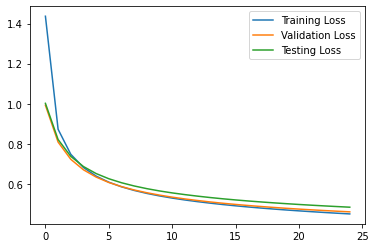

In [56]:
#Training and Testing Overfitting Model
training_loss = []
testing_loss = []
validation_loss = []
#---------------------
model_overfit = OverfitNeuralNetwork().cuda()

for epoch in range(25):
  loss_per_epoch = 0
  for idx, data in enumerate(train_loader):
    features, labels = data
    features = features.cuda()
    labels = labels.cuda()
    probs = model_overfit(features.reshape([-1, 784]))
    loss = ce_loss(probs, labels)
    loss_per_epoch = loss_per_epoch + loss.item()

    for param in model_overfit.parameters():
      param.grad = None

    loss.backward()

    for name, param in model_overfit.named_parameters():
      new_param = param - learning_rate * param.grad    
      with torch.no_grad():
        param.copy_(new_param)
        
  avg_loss_per_iter = loss_per_epoch/len(train_loader);
  training_loss.append(avg_loss_per_iter)
  
  testing_loss_per_epoch = 0
  for idx, data in enumerate(test_loader):
    features, labels = data
    features = features.cuda()
    labels = labels.cuda()

    with torch.no_grad():
      probs = model_overfit(features.reshape([-1, 784]))
      predicts = torch.argmax(probs, dim=1)
      tloss = ce_loss(probs, labels)
      testing_loss_per_epoch = testing_loss_per_epoch + tloss.item()

  avg_loss_per_iter = testing_loss_per_epoch/len(test_loader);
  testing_loss.append(avg_loss_per_iter)

  validation_loss_per_epoch = 0
  for idx, data in enumerate(valid_loader):
    features, labels = data
    features = features.cuda()
    labels = labels.cuda()

    with torch.no_grad():
      probs = model_overfit(features.reshape([-1, 784]))
      predicts = torch.argmax(probs, dim=1)
      vloss = ce_loss(probs, labels)
      validation_loss_per_epoch = validation_loss_per_epoch + vloss.item()

  avg_loss_per_iter = validation_loss_per_epoch/len(valid_loader);
  validation_loss.append(avg_loss_per_iter)

print(f"Training_Loss {training_loss}")
print(f"Testing_Loss {testing_loss}")
print(f"Validation_Loss {validation_loss}")
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.plot(testing_loss, label='Testing Loss')
plt.legend()
plt.show()

The general difference between overfitting and underfitting is that in case of underfitting the model cannot capture the complexity of the data leading to increase in training and test error thereby impacting the performance of the model. 
Whereas in case of the overfitting the model shows training error as almost negligible but when the model is run in real-life where the data is noisy. The overfitted model which leads to a very high training accuracy but very low test accuracy and high testing loss. This reduces the generalisation capacity of the model when it is run on the new testing data.

Usually the model is underfit when it has less number of neurons per hidden layer or has less number of hidden layers in the network. 
Overfitting occurs when we increase the complexity of the network i.e be increasing the number of hidden layers in the network or increasing the number of neurons per layer. 

As can be seen above it is observed that when I decreased the number of neurons per layer in the UnderfitNeuralNetwork the training, testing as well as validation loss increases as compared to the loss we had when the number of neursons were more in our original model.

Also, in case of overfitting I incresased the number of layers in the network thereby adding to the complexity of the network - class OverfitNeuralNetwork. This lead to the improvement in the training loss (it decreased from that of the original network) and then when the model was tested on the test load the testing loss increased. Leading to poor performance of the network.

Reference:


1.   https://medium.com/unpackai/cross-entropy-loss-in-ml-d9f22fc11fe0 
2.   https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function 
3.   https://en.wikipedia.org/wiki/One-hot 
4. https://medium.com/@xaviergeerinck/artificial-intelligence-how-to-measure-performance-accuracy-precision-recall-f1-roc-rmse-611d10e4caac
5. https://torchmetrics.readthedocs.io/en/stable/classification/auroc.html

